In [1]:
import sys
sys.path.append('/home/pranavsatheesh/host_galaxies/')

In [2]:
import illustris_python as il
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

In [3]:
SOLAR_MASS_G = 1.989e33
MSOL = 1.988409870698051e+33
h = 0.6774

In [4]:
basePath = '/orange/lblecha/IllustrisTNG/Runs/TNG50-1/output'
merger_file_path = '/home/pranavsatheesh/host_galaxies/data/merger_files'

In [5]:
# Load scale factors and redshifts
snap_list = np.arange(1,100)
redshifts = np.array([il.groupcat.loadHeader(basePath, snap)['Redshift'].item() for snap in snap_list])
scale_factors = np.array([il.groupcat.loadHeader(basePath, snap)['Time'].item() for snap in snap_list])

In [8]:
merger_file_1bh = merger_file_path+'/galaxy-mergers_TNG50-1_gas-100_dm-100_star-100_bh-001.hdf5'#merger file
merger_file_nobh = merger_file_path+'/galaxy-mergers_TNG50-1_gas-100_dm-100_star-100_bh-000.hdf5'
merger_file_nobh_star_1000 = merger_file_path+'/galaxy-mergers_TNG50-1_gas-000_dm-000_star-1000_bh-000.hdf5' 

In [9]:
#mergers = h5py.File(merger_file_1bh, 'r')
fmergers = h5py.File(merger_file_nobh_star_1000, 'r')
fmergers.keys()

<KeysViewHDF5 ['InfallMassRatio', 'ProgMassRatio', 'ProgMassRatio_mod', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloCM', 'SubhaloGrNr', 'SubhaloHalfmassRadType', 'SubhaloLenType', 'SubhaloMassInHalfRadType', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloPos', 'SubhaloSFR', 'SubhaloVel', 'SubhaloVelDisp', 'fpMass', 'fpMass_mod', 'fpMasshistory', 'fpinfallMass', 'fpsnaphistory', 'npMass', 'npMass_mod', 'npMasshistory', 'npinfallMass', 'npsnaphistory', 'shids_subf', 'shids_tree', 'snaps', 'time']>

In [10]:
def get_scale_factors(basePath, filename="output_scale_factors.txt"):
    path = basePath.split('/output')[0]
    #print(path)
    f = open(path+"/"+filename,'r')
    snaptimes = np.array([float(line) for line in f.readlines()])
    f.close()
    print(f"snapshot scale factors in {path}:")
    print(snaptimes)
    return snaptimes

In [11]:
scale_factors_tng = get_scale_factors(basePath)
one_plus_z = 1.0 / scale_factors_tng

snapshot scale factors in /orange/lblecha/IllustrisTNG/Runs/TNG50-1:
[0.04751386 0.06254232 0.07704034 0.08350282 0.09093728 0.09625777
 0.09997661 0.10582597 0.11096103 0.11634526 0.12141409 0.12491542
 0.13348287 0.14263794 0.1460576  0.15314485 0.16057599 0.1667797
 0.17653754 0.18422877 0.19316822 0.1996827  0.21236949 0.22267443
 0.2334794  0.24949284 0.25668768 0.26787083 0.2795412  0.29034102
 0.30155808 0.31172794 0.32224077 0.33310814 0.344342   0.35427208
 0.36448853 0.37499959 0.38398999 0.39506344 0.40071935 0.41423335
 0.42416436 0.43433346 0.44474635 0.45325613 0.46412269 0.47300321
 0.48205365 0.49127726 0.50067736 0.51268081 0.52002058 0.52997065
 0.54011111 0.55044559 0.55832602 0.56900902 0.57715521 0.5881985
 0.59661941 0.60803512 0.61674002 0.62556955 0.63452548 0.64666649
 0.65592445 0.66531496 0.6748399  0.68450121 0.69430083 0.70424076
 0.71432298 0.72454955 0.73492252 0.74192021 0.75254187 0.76331559
 0.77058363 0.78532797 0.7928056  0.80415576 0.81566841 0.8234

In [14]:
len(fmergers['InfallMassRatio'])

15383

(1000000.0, 130405671055.79947)

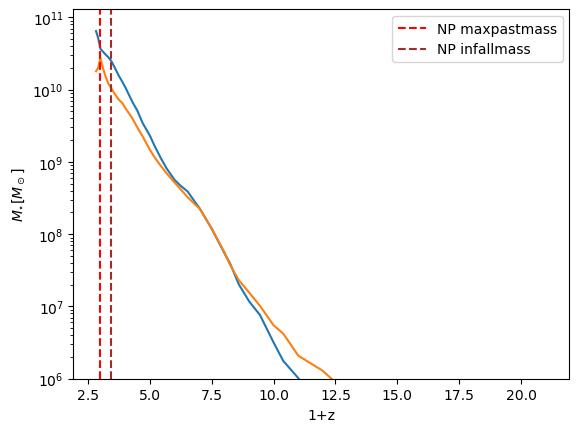

In [10]:
plt.plot(one_plus_z[fmergers['fpsnaphistory'][0].astype(int)], fmergers['fpMasshistory'][0] * 10**10 / h)
plt.plot(one_plus_z[fmergers['npsnaphistory'][0].astype(int)], fmergers['npMasshistory'][0] * 10**10 / h)
#plt.scatter(fmergers['fpinfallMass'][0]*10**10 / h)
npmaxpastmass_index = np.where(fmergers['npMasshistory'][0]*1e10/h==fmergers['npMass'][0])[0][0]
npinfallmass_index = np.where(fmergers['npMasshistory'][0]*1e10/h==fmergers['npinfallMass'][0])[0][0]
plt.axvline(one_plus_z[fmergers['npsnaphistory'][0][npmaxpastmass_index].astype(int)], color='red', linestyle='--', label='NP maxpastmass')
plt.axvline(one_plus_z[fmergers['npsnaphistory'][0][npinfallmass_index].astype(int)], color='brown', linestyle='--', label='NP infallmass')
plt.legend()
plt.yscale('log',base=10)
plt.xlabel('1+z')
plt.ylabel('$M_{\star}$[$M_\odot$]')
plt.ylim(1e6,)

In [8]:
hubble_param = fmergers.attrs['HubbleParam']
print(hubble_param)
#_ids = fmergers['shids_tree']
descendent_ids = fmergers['shids_tree'][:,2].flatten()

0.6774


Text(0, 0.5, 'Number of galaxy mergers with Nbh = 1')

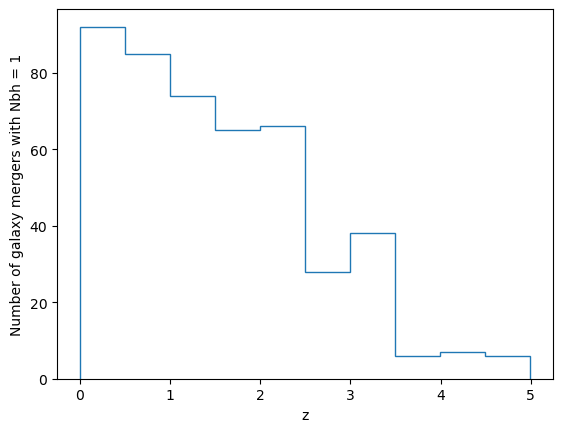

In [9]:
subhaloidxs_galaxy_mergers = fmergers["shids_subf"][:,2]
#using the descendent progenitor pointer
snaps_galaxy_mergers = fmergers['snaps'][:,2]

#redshifts of host galaxies of MBHBs will be indicated by the dominant progenitor
z_galaxy_mergers = 1/(fmergers['time'][:][:,2])-1

plt.hist(z_galaxy_mergers,bins=10,histtype="step")
plt.xlabel("z")
plt.ylabel("Number of galaxy mergers with Nbh = 1")

In [10]:
np.sum(fmergers['SubhaloBHMass'][:][:,0]==0)
np.sum(fmergers['SubhaloBHMass'][:][:,1]==0)
np.sum(fmergers['SubhaloBHMass'][:][:,2]==0)

print("Number of descendents with zero black holes: ",np.sum(fmergers['SubhaloBHMass'][:][:,2]==0))

Number of descendents with zero black holes:  7


#### should discard these cases

In [11]:
box_length = fmergers.attrs['box_volume_mpc']**(1/3) * 1000

#### checking subfindID and subhalo index within a snapshot

In [12]:
def get_valid_subhalo_ids(subhalos):

        #applying the minimum particle cu
    Ngas = subhalos['SubhaloLenType'][:, 0]
    Ndm = subhalos['SubhaloLenType'][:, 1]
    Nstar = subhalos['SubhaloLenType'][:, 4]
    Nbh = subhalos['SubhaloLenType'][:, 5]
    subhalo_ids = np.arange(len(Ngas))
    #particle_cut_mask = (Ngas >= self.minN_values[1]) & (Ndm >= self.minN_values[0]) & (Nstar >= self.minN_values[2]) & (Nbh >= 0)
    particle_cut_mask = (Ngas >= 100) & (Ndm >= 100) & (Nstar >= 100) & (Nbh >= 1)

    #applying the condition that the nearest neighbour sep rsep >2 for non interacting galaxies

    valid_subhalo_ids = subhalo_ids[particle_cut_mask]
    valid_subhalo_pos = subhalos['SubhaloPos'][particle_cut_mask]

    tree = cKDTree(valid_subhalo_pos, boxsize=box_length)
    distances, nearest_neighbors = tree.query(valid_subhalo_pos,k=2)

    nearest_subhalo_ids = nearest_neighbors[:,-1]
    r_subhalos = distances[:,-1]

    stellar_half_mass_radius = subhalos['SubhaloHalfmassRadType'][:,4]/h

    r_sep = r_subhalos/(stellar_half_mass_radius[valid_subhalo_ids]+stellar_half_mass_radius[nearest_subhalo_ids])

    valid_sep_mask = r_sep>2

    return valid_subhalo_ids[valid_sep_mask]

In [13]:
snapNum = 35
subhalos = il.groupcat.loadSubhalos(basePath, snapNum, fields=['SubhaloLenType', 'SubhaloMassType', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloSFR','SubhaloGasMetallicity','SubhaloStarMetallicity','SubhaloPos','SubhaloHalfmassRadType'])

In [14]:
valid_subs = get_valid_subhalo_ids(subhalos)

In [15]:
fields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID', 'FirstProgenitorID',
              'LastProgenitorID', 'RootDescendantID', 'SubhaloLenType', 'SubhaloMassType',
              'SnapNum', 'DescendantID', 'SubfindID','FirstSubhaloInFOFGroupID']


In [16]:
def find_past_major_merger(tree,massratio=0.1):
    index=0
    minMassRatio = massratio
    invMinMassRatio = 1.0/massratio
    minNgas = 100
    minNdm = 100
    minNstar = 100
    minNbh = 0


    rootID = tree['SubhaloID'][index]
    fpID   = tree['FirstProgenitorID'][index]
    rootSnap = tree['SnapNum'][index]
    fpSnap = rootSnap
    fdesID = tree['DescendantID'][index]

    while fpID != -1:
        fpIndex = index + (fpID - rootID)
        fpMass  = il.sublink.maxPastMass(tree, fpIndex)
        fpNpart = tree['SubhaloLenType'][fpIndex,:]

        npID = tree['NextProgenitorID'][fpIndex]
        npSnap = tree['SnapNum'][fpIndex]
        ndesID = tree['DescendantID'][fpIndex]

        fdesIndex = index + (fdesID - rootID)
        while npID != -1:
            npIndex = index + (npID - rootID)
            npMass  = il.sublink.maxPastMass(tree, npIndex)
            npNpart = tree['SubhaloLenType'][npIndex,:]
            ndesIndex = index + (ndesID - rootID)
            if fpMass > 0.0 and npMass > 0.0:
                ratio = npMass / fpMass
                if (ratio >= minMassRatio and ratio <= invMinMassRatio and min(npNpart[0], fpNpart[0]) >= minNgas and min(npNpart[1], fpNpart[1]) >= minNdm and min(npNpart[4], fpNpart[4]) >= minNstar and min(npNpart[5], fpNpart[5]) >= minNbh):
                    print("yes")
                    print(tree["SubfindID"][ndesIndex],tree["SubfindID"][fpIndex],tree["SubfindID"][npIndex])
            npID = tree['NextProgenitorID'][npIndex]
            npSnap = tree['SnapNum'][npIndex]
            ndesID = tree['DescendantID'][npIndex]
        fpID = tree['NextProgenitorID'][fpIndex]
        fpSnap = tree['SnapNum'][fpIndex]
        fdesID = tree['DescendantID'][fpIndex]

    return tree["SubfindID"][ndesIndex],tree["SubfindID"][fpIndex],tree["SubfindID"][npIndex]

In [ ]:
for sub_i in tqdm(valid_subs):
    tree = il.sublink.loadTree(basePath,snapNum,valid_subs[0], fields=fields, onlyMPB=False)
    find_past_major_merger(tree)

  0%|          | 0/3250 [00:00<?, ?it/s]

  2%|▏         | 71/3250 [09:58<7:26:26,  8.43s/it]


-1

In [16]:
tree['SubfindID'][0]

0

In [ ]:
subhalos['SubhaloBHMass'][79673]* 1e10 / 0.6774

64434096.764895216

In [ ]:
fmergers['snaps'][2]

array([21, 20, 22])

In [ ]:
np.where(z_galaxy_mergers>4)

(array([  5,   9,  31,  33, 135, 136, 138, 169, 193, 228, 229, 230, 335]),)

In [ ]:
snapNum = 36
sub_lentype = il.groupcat.loadSubhalos(basePath, snapNum, fields=['SubhaloLenType'])


Ngas = sub_lentype[:,0]
Ndm = sub_lentype[:,1]
Nstar = sub_lentype[:,4]
Nbh = sub_lentype[:,5]

minNdm=100
minNgas=100
minNstar=100
minNbh=1

## Binning the redshifts and snap numbers

In [ ]:
dz = 1
min_z = 0
max_z = 6

z_bins = np.arange(min_z, max_z + dz, dz)
print(z_bins)

[0 1 2 3 4 5 6]


In [ ]:
# merging galaxy sampled by redshifts 
z_bin_indices_mergers = np.digitize(z_galaxy_mergers,z_bins, right=False)
#Group them by redshift, snap number and subhalo IDs. Use the subhaloIDs to cross reference with the subfind subhalo catalogue

In [ ]:
max(z_galaxy_mergers)

np.float64(4.995933485958621)

In [ ]:
np.min(snaps_galaxy_mergers)

np.int64(17)

In [ ]:
# 0<z<1
# z_bin_indices_mergers = 1
print(f"This bin corresponds to redshifts 0=<z<1")
print(f"The redshifts of the first 3 mergers in this bin is {z_galaxy_mergers[z_bin_indices_mergers==1][:3]}")
print(f"The redshifts of the first 3 mergers in this bin is {snaps_galaxy_mergers[z_bin_indices_mergers==1][:3]}")
print(f"The redshifts of the first 3 mergers in this bin is {subhaloidxs_galaxy_mergers[z_bin_indices_mergers==1][:3]}")

This bin corresponds to redshifts 0=<z<1
The redshifts of the first 3 mergers in this bin is [0.64464184 0.73263618 0.54639218]
The redshifts of the first 3 mergers in this bin is [61 58 65]
The redshifts of the first 3 mergers in this bin is [341236  47221  93009]


In [ ]:
#get all the unique snapshot numbers within this redshift bin that corresponds to a galaxy merger
snaps_where_merger = np.unique(snaps_galaxy_mergers[z_bin_indices_mergers==1])
print(snaps_where_merger)

[50 51 52 53 54 55 56 57 58 59 60 61 62 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 89 90 91 92 93 94 95 96 97 98 99]


In [ ]:
z_bin_indices_all = np.digitize(redshifts,z_bins,right=False)

### Creating a non-merging sample in the redshift bin

*for each snapshots, load the subhalo informations and check for the snap numbers and subhalo IDs in the merger population and exclude them from the non-merging sample*

In [ ]:
snap_list[z_bin_indices_all==1]

array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
def load_subhalo_info(basePath, snapNum,minN_values,snaps_galaxy_mergers, subhaloidxs_galaxy_mergers):
    subhalos = il.groupcat.loadSubhalos(basePath, snapNum, fields=['SubhaloLenType','SubhaloMassType','SubhaloBHMass','SubhaloBHMdot','SubhaloSFR'])
    Ngas = subhalos['SubhaloLenType'][:,0]
    Ndm = subhalos['SubhaloLenType'][:,1]
    Nstar = subhalos['SubhaloLenType'][:,4]
    Nbh = subhalos['SubhaloLenType'][:,5]
    subhalo_ids = np.arange(len(Ngas))
    #subhalo_ids = subhalo_ids[(Ngas>=minN_values[0]) & (Ndm>=minNdm) & (Nstar>=minNstar) & (Nbh>=minNbh)] #applying the minimum number of particles cut
    subhalo_ids = subhalo_ids[(Ngas >= minN_values[1]) & (Ndm >= minN_values[0]) & (Nstar >= minN_values[2]) & (Nbh >= minN_values[3])] # applying the minimum number of particles cut
    #subhaloidxs_galaxy_mergers[np.where(snaps_galaxy_mergers==snapNum)]

    subhalo_ids_merging = subhaloidxs_galaxy_mergers[np.where(snaps_galaxy_mergers==snapNum)]

    if subhalo_ids_merging.size == 0:
        print(f"No galaxy mergers at snapNum {snapNum}")
        return None

    else:    
        subhalo_ids_non_merging = np.setdiff1d(subhalo_ids,subhalo_ids_merging)

        Mstar_merging = subhalos['SubhaloMassType'][subhalo_ids_merging,4]
        Mgas_merging = subhalos['SubhaloMassType'][subhalo_ids_merging,0]
        MBH_merging = subhalos['SubhaloBHMass'][subhalo_ids_merging]
        Mdot_merging = subhalos['SubhaloBHMdot'][subhalo_ids_merging]
        SFR_merging = subhalos['SubhaloSFR'][subhalo_ids_merging]

        Mstar_non_merging = subhalos['SubhaloMassType'][subhalo_ids_non_merging,4]
        Mgas_non_merging = subhalos['SubhaloMassType'][subhalo_ids_non_merging,0]
        MBH_non_merging = subhalos['SubhaloBHMass'][subhalo_ids_non_merging]    
        Mdot_non_merging = subhalos['SubhaloBHMdot'][subhalo_ids_non_merging]
        SFR_non_merging = subhalos['SubhaloSFR'][subhalo_ids_non_merging]

    merging_population = {
        "subhalo_ids": subhalo_ids_merging,
        "Mstar": Mstar_merging,
        "Mgas": Mgas_merging,
        "MBH": MBH_merging,
        "Mdot": Mdot_merging,
        "SFR": SFR_merging
    }

    non_merging_population = {
        "subhalo_ids": subhalo_ids_non_merging,
        "Mstar": Mstar_non_merging,
        "Mgas": Mgas_non_merging,
        "MBH": MBH_non_merging,
        "Mdot": Mdot_non_merging,
        "SFR": SFR_non_merging
    }

    return merging_population, non_merging_population

In [ ]:
z_bin_indices_all

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 5, 5, 5, 5, 5, 4,
       4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
def generate_population(basePath, snap_list, snaps_galaxy_mergers, subhaloidxs_galaxy_mergers, minN_values):
    merging_population = {
        "snap": [],
        "subhalo_ids": [],
        "Mstar": [],
        "Mgas": [],
        "MBH": [],
        "Mdot": [],
        "SFR": []
    }
    
    non_merging_population = {
        "snap": [],
        "subhalo_ids": [],
        "Mstar": [],
        "Mgas": [],
        "MBH": [],
        "Mdot": [],
        "SFR": []
    }

    for snap in snap_list:
        subhalos = il.groupcat.loadSubhalos(basePath, snap, fields=['SubhaloLenType', 'SubhaloMassType', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloSFR'])
        Ngas = subhalos['SubhaloLenType'][:, 0]
        Ndm = subhalos['SubhaloLenType'][:, 1]
        Nstar = subhalos['SubhaloLenType'][:, 4]
        Nbh = subhalos['SubhaloLenType'][:, 5]
        subhalo_ids = np.arange(len(Ngas))
        subhalo_ids = subhalo_ids[(Ngas >= minN_values[1]) & (Ndm >= minN_values[0]) & (Nstar >= minN_values[2]) & (Nbh >= minN_values[3])]

        subhalo_ids_merging = subhaloidxs_galaxy_mergers[np.where(snaps_galaxy_mergers == snap)]
        subhalo_ids_non_merging = np.setdiff1d(subhalo_ids, subhalo_ids_merging)

        merging_population["snap"].extend(snap)
        merging_population["subhalo_ids"].extend(subhalo_ids_merging)
        merging_population["Mstar"].extend(subhalos['SubhaloMassType'][subhalo_ids_merging, 4])
        merging_population["Mgas"].extend(subhalos['SubhaloMassType'][subhalo_ids_merging, 0])
        merging_population["MBH"].extend(subhalos['SubhaloBHMass'][subhalo_ids_merging])
        merging_population["Mdot"].extend(subhalos['SubhaloBHMdot'][subhalo_ids_merging])
        merging_population["SFR"].extend(subhalos['SubhaloSFR'][subhalo_ids_merging])

        non_merging_population["snap"].extend(snap)
        non_merging_population["subhalo_ids"].extend(subhalo_ids_non_merging)
        non_merging_population["Mstar"].extend(subhalos['SubhaloMassType'][subhalo_ids_non_merging, 4])
        non_merging_population["Mgas"].extend(subhalos['SubhaloMassType'][subhalo_ids_non_merging, 0])
        non_merging_population["MBH"].extend(subhalos['SubhaloBHMass'][subhalo_ids_non_merging])
        non_merging_population["Mdot"].extend(subhalos['SubhaloBHMdot'][subhalo_ids_non_merging])
        non_merging_population["SFR"].extend(subhalos['SubhaloSFR'][subhalo_ids_non_merging])

    return merging_population, non_merging_population

In [ ]:
def generate_population(basePath,snap_list,snaps_galaxy_mergers, subhaloidxs_galaxy_mergers, minN_values):

    merging_population = []
    non_merging_population = []
    for snap in snap_list:
        subhalos = il.groupcat.loadSubhalos(basePath, snap, fields=['SubhaloLenType', 'SubhaloMassType', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloSFR'])
        Ngas = subhalos['SubhaloLenType'][:, 0]
        Ndm = subhalos['SubhaloLenType'][:, 1]
        Nstar = subhalos['SubhaloLenType'][:, 4]
        Nbh = subhalos['SubhaloLenType'][:, 5]
        subhalo_ids = np.arange(len(Ngas))
        subhalo_ids = subhalo_ids[(Ngas >= minN_values[1]) & (Ndm >= minN_values[0]) & (Nstar >= minN_values[2]) & (Nbh >= minN_values[3])]

        subhalo_ids_merging = subhaloidxs_galaxy_mergers[np.where(snaps_galaxy_mergers == snap)]
        subhalo_ids_non_merging = np.setdiff1d(subhalo_ids, subhalo_ids_merging)

        merging_population.append({
                "snap": snap,
                "subhalo_ids": subhalo_ids_merging,
                "Mstar": subhalos['SubhaloMassType'][subhalo_ids_merging, 4],
                "Mgas": subhalos['SubhaloMassType'][subhalo_ids_merging, 0],
                "MBH": subhalos['SubhaloBHMass'][subhalo_ids_merging],
                "Mdot": subhalos['SubhaloBHMdot'][subhalo_ids_merging],
                "SFR": subhalos['SubhaloSFR'][subhalo_ids_merging]
            })

        non_merging_population.append({
                "snap": snap,
                "subhalo_ids": subhalo_ids_non_merging,
                "Mstar": subhalos['SubhaloMassType'][subhalo_ids_non_merging, 4],
                "Mgas": subhalos['SubhaloMassType'][subhalo_ids_non_merging, 0],
                "MBH": subhalos['SubhaloBHMass'][subhalo_ids_non_merging],
                "Mdot": subhalos['SubhaloBHMdot'][subhalo_ids_non_merging],
                "SFR": subhalos['SubhaloSFR'][subhalo_ids_non_merging]
            })

    return merging_population, non_merging_population

In [ ]:
import numpy as np

def generate_population(basePath, snap_list, snaps_galaxy_mergers, subhaloidxs_galaxy_mergers, minN_values):
    merging_population = {
        "snap": np.array([]),
        "subhalo_ids": np.array([]),
        "Mstar": np.array([]),
        "Mgas": np.array([]),
        "MBH": np.array([]),
        "Mdot": np.array([]),
        "SFR": np.array([])
    }
    
    non_merging_population = {
        "snap": np.array([]),
        "subhalo_ids": np.array([]),
        "Mstar": np.array([]),
        "Mgas": np.array([]),
        "MBH": np.array([]),
        "Mdot": np.array([]),
        "SFR": np.array([])
    }

    for snap in snap_list:
        subhalos = il.groupcat.loadSubhalos(basePath, snap, fields=['SubhaloLenType', 'SubhaloMassType', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloSFR'])
        Ngas = subhalos['SubhaloLenType'][:, 0]
        Ndm = subhalos['SubhaloLenType'][:, 1]
        Nstar = subhalos['SubhaloLenType'][:, 4]
        Nbh = subhalos['SubhaloLenType'][:, 5]
        subhalo_ids = np.arange(len(Ngas))
        subhalo_ids = subhalo_ids[(Ngas >= minN_values[1]) & (Ndm >= minN_values[0]) & (Nstar >= minN_values[2]) & (Nbh >= minN_values[3])]

        subhalo_ids_merging = subhaloidxs_galaxy_mergers[np.where(snaps_galaxy_mergers == snap)]
        subhalo_ids_non_merging = np.setdiff1d(subhalo_ids, subhalo_ids_merging)

        merging_population["snap"] = np.concatenate((merging_population["snap"], snap))
        merging_population["subhalo_ids"] = np.concatenate((merging_population["subhalo_ids"], subhalo_ids_merging))
        merging_population["Mstar"] = np.concatenate((merging_population["Mstar"], subhalos['SubhaloMassType'][subhalo_ids_merging, 4]))
        merging_population["Mgas"] = np.concatenate((merging_population["Mgas"], subhalos['SubhaloMassType'][subhalo_ids_merging, 0]))
        merging_population["MBH"] = np.concatenate((merging_population["MBH"], subhalos['SubhaloBHMass'][subhalo_ids_merging]))
        merging_population["Mdot"] = np.concatenate((merging_population["Mdot"], subhalos['SubhaloBHMdot'][subhalo_ids_merging]))
        merging_population["SFR"] = np.concatenate((merging_population["SFR"], subhalos['SubhaloSFR'][subhalo_ids_merging]))

        non_merging_population["snap"] = np.concatenate((non_merging_population["snap"], snap))
        non_merging_population["subhalo_ids"] = np.concatenate((non_merging_population["subhalo_ids"], subhalo_ids_non_merging))
        non_merging_population["Mstar"] = np.concatenate((non_merging_population["Mstar"], subhalos['SubhaloMassType'][subhalo_ids_non_merging, 4]))
        non_merging_population["Mgas"] = np.concatenate((non_merging_population["Mgas"], subhalos['SubhaloMassType'][subhalo_ids_non_merging, 0]))
        non_merging_population["MBH"] = np.concatenate((non_merging_population["MBH"], subhalos['SubhaloBHMass'][subhalo_ids_non_merging]))
        non_merging_population["Mdot"] = np.concatenate((non_merging_population["Mdot"], subhalos['SubhaloBHMdot'][subhalo_ids_non_merging]))
        non_merging_population["SFR"] = np.concatenate((non_merging_population["SFR"], subhalos['SubhaloSFR'][subhalo_ids_non_merging]))

    return merging_population, non_merging_population

In [ ]:
generate_population(basePath, snap_list[z_bin_indices_all==7],snaps_galaxy_mergers, subhaloidxs_galaxy_mergers, [100,100,100,1])


({'snap': array([], dtype=float64),
  'subhalo_ids': array([], dtype=float64),
  'Mstar': array([], dtype=float64),
  'Mgas': array([], dtype=float64),
  'MBH': array([], dtype=float64),
  'Mdot': array([], dtype=float64),
  'SFR': array([], dtype=float64)},
 {'snap': array([ 3.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,
          6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,
          7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
          7.,  7.,  7.,  7.,  7.,  7.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,
          8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
          8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
          9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
          9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
          9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
          9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9., 10.

In [ ]:
snap_list[z_bin_indices_all==7]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [ ]:
load_subhalo_info(basePath,50, [100,100,100,0],snaps_galaxy_mergers, subhaloidxs_galaxy_mergers)

({'subhalo_ids': array([118813, 141965, 260976, 270433, 342706, 481754]),
  'Mstar': array([23.065054  , 22.352777  ,  4.573118  ,  0.1360099 ,  0.7567003 ,
          0.09303249], dtype=float32),
  'Mgas': array([44.798065  , 32.56616   ,  9.358537  ,  0.24912122,  4.8203664 ,
          1.1250806 ], dtype=float32),
  'MBH': array([0.04436299, 0.05153645, 0.00897015, 0.00042717, 0.00193776,
         0.0003887 ], dtype=float32),
  'Mdot': array([3.0046524e-04, 2.6690270e-04, 1.8073363e-02, 6.2764855e-03,
         1.1863491e-03, 9.6196403e-05], dtype=float32),
  'SFR': array([16.623947 , 17.580204 , 27.262686 , 11.100195 ,  6.2332196,
          1.0928594], dtype=float32)},
 {'subhalo_ids': array([      0,       1,       2, ..., 1008304, 1010802, 1123831]),
  'Mstar': array([6.0826576e+01, 3.0320320e+01, 2.2540743e+01, ..., 4.9528747e-04,
         9.8899007e-04, 4.1565960e-04], dtype=float32),
  'Mgas': array([3.4269260e+02, 3.7184429e+01, 1.0845090e+01, ..., 6.9189008e-04,
         1.2332

### Testing the python code

In [1]:
import sys
import os
sys.path.append(os.path.abspath('/home/pranavsatheesh/host_galaxies/py_files'))
import population_sort_by_mergers as pop

In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import h5py
import numpy as np

In [2]:
basePath = '/orange/lblecha/IllustrisTNG/Runs/TNG50-1/output'
merger_file_Path = '/home/pranavsatheesh/host_galaxies/data/merger_files'

merger_file_1bh = merger_file_Path+'/galaxy-mergers_TNG50-1_gas-100_dm-100_star-100_bh-001.hdf5'

merger_file_nobh = merger_file_Path+'/galaxy-mergers_TNG50-1_gas-100_dm-100_star-100_bh-000.hdf5'

In [3]:
# Load scale factors and redshifts
snap_list = np.arange(1,100)
redshifts = np.array([il.groupcat.loadHeader(basePath, snap)['Redshift'].item() for snap in snap_list])
snap_to_redshift = dict(zip(snap_list, redshifts))
scale_factors = np.array([il.groupcat.loadHeader(basePath, snap)['Time'].item() for snap in snap_list])

In [4]:
fmergers = h5py.File(merger_file_1bh, 'r')
fmergers.keys()

<KeysViewHDF5 []>

In [15]:
np.size(fmergers['fpMass'][:])

467

In [17]:
np.size(fmergers['npsnaphistory'][:])

21025

In [ ]:
fmergers = h5py.File(merger_file_1bh, 'r')
subhaloidxs_galaxy_mergers = fmergers["shids_subf"][:,2]
#using the descendent progenitor pointer
snaps_galaxy_mergers = fmergers['snaps'][:,2]
z_galaxy_mergers = 1/(fmergers['time'][:][:,2])-1

In [ ]:
fmergers.keys()

<KeysViewHDF5 ['ProgMassRatio', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloCM', 'SubhaloGrNr', 'SubhaloHalfmassRadType', 'SubhaloLenType', 'SubhaloMassInHalfRadType', 'SubhaloMassInRadType', 'SubhaloMassType', 'SubhaloPos', 'SubhaloSFR', 'SubhaloVel', 'SubhaloVelDisp', 'fpMass', 'npMass', 'shids_subf', 'shids_tree', 'snaps', 'time']>

## More than one merger ?

In [ ]:
print(np.where(snaps_galaxy_mergers ==17),subhaloidxs_galaxy_mergers [np.where(snaps_galaxy_mergers ==17)])

(array([136, 228, 229, 230]),) [8136 5667 5663 5663]


In [ ]:
print(fmergers['snaps'][:][229],fmergers['snaps'][:][230])

[16 15 17] [16 16 17]


In [ ]:
print(fmergers['SubhaloBHMass'][:][229]/MSOL,fmergers['SubhaloBHMass'][:][230]/MSOL)

[ 5755661.84515882  1480946.95201405 13875264.48909551] [ 5755661.84515882  1994543.41670551 13875264.48909551]
